# Convo. Neural Network for defining word boundaries

## Setup

In [1]:
import os

import numpy as np
np.complex = complex # Because of librosa compatibility issues
np.float = float
import pandas as pd
import random

import librosa
import soundfile as sf
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

/Users/sidneyma/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Audio preprocessing (log-mel features)

In [2]:
os.makedirs("audio_features", exist_ok=True)
df = pd.read_csv("augmented_data.csv")

# Feature configurations
N_MELS = 64
HOP_LENGTH = 160 # 10ms at 16kHz
WIN_LENGTH = 400 # 25ms at 16kHz
DURATION = 2 # Clip length (seconds)
SR = 16000
N_FRAMES = int(DURATION * SR / HOP_LENGTH)

# Get log-mel features
features = []
targets = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    path = os.path.join("aug_audio", row["audio"])
    y, _ = librosa.load(path, sr=SR)

    mel = librosa.feature.melspectrogram(
        y=y, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH, win_length=WIN_LENGTH
    )
    log_mel = librosa.power_to_db(mel, ref=np.max)

    # Pad/truncate to fixed frame length
    if log_mel.shape[1] > N_FRAMES:
        log_mel = log_mel[:, :N_FRAMES]
    else:
        pad_width = N_FRAMES - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode="constant")

    # Save features
    file_id = row["audio"].replace(".wav", "")
    feature_path = os.path.join("audio_features", f"{file_id}.npy")
    np.save(feature_path, log_mel)

    features.append(feature_path)
    targets.append((row["start_time"], row["end_time"]))

# Save data
df_processed = pd.DataFrame({
    "audio": df["audio"],
    "feature_path": features,
    "start_time": [t[0] for t in targets],
    "end_time": [t[1] for t in targets]
})

df_processed

100%|████████████████████████████████████| 10000/10000 [01:06<00:00, 149.92it/s]


,audio,feature_path,start_time,end_time
0,flag_0.wav,audio_features/flag_0.npy,0.734800,1.483000
1,flag_1.wav,audio_features/flag_1.npy,0.617378,1.369601
2,flag_2.wav,audio_features/flag_2.npy,0.837397,1.648270
3,flag_3.wav,audio_features/flag_3.npy,0.731869,1.405390
4,flag_4.wav,audio_features/flag_4.npy,0.817532,1.633205
...,...,...,...,...
9995,plot_45.wav,audio_features/plot_45.npy,0.630127,1.329961
9996,plot_46.wav,audio_features/plot_46.npy,0.709757,1.428919
9997,plot_47.wav,audio_features/plot_47.npy,0.785457,1.550323
9998,plot_48.wav,audio_features/plot_48.npy,0.608701,1.208141


## Neural Network setup

In [21]:
# Dataset class
class AudioTimingDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        features = np.load(row["feature_path"])
        x = torch.tensor(features, dtype=torch.float32) # [64, 200]
        start = row["start_time"]
        end = row["end_time"]
        y = torch.tensor([start, end], dtype=torch.float32)
        return x, y


# CNN class
class BoundaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(256 * 50, 64)
        self.fc2 = nn.Linear(64, 2)  # [start, end]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 64, 100]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 50]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Training
def train_model(model, loader, optimizer, device, epochs=10,
                lambda_invalid=1.0, lambda_narrow=1.0, lambda_wide=0.25):
    # lambda_invalid: penalty for end < start
    # lambda_narrow: penalty for not fully covering ground truth
    # lambda_wide: soft penalty for overlong predictions
    
    model.to(device)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x, y in tqdm(loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            preds = model(x)  # [B, 2]
            pred_start, pred_end = preds[:, 0], preds[:, 1]
            true_start, true_end = y[:, 0], y[:, 1]

            # Default loss
            mse_loss = loss_fn(preds, y)

            # Invalid window penalty (if start > end)
            invalid_window = torch.relu(pred_start - pred_end).mean()

            # Penalty for not encapsulating true boundary
            late_start = torch.relu(pred_start - true_start)
            early_end = torch.relu(true_end - pred_end)
            narrow_penalty = (late_start + early_end).mean()

            # Penalty for excessively large window (balance previous penalty)
            pred_width = pred_end - pred_start
            true_width = true_end - true_start
            wide_penalty = torch.relu(pred_width - true_width * 1.5).mean()

            # Total loss
            loss = mse_loss \
                 + lambda_invalid * invalid_window \
                 + lambda_narrow * narrow_penalty \
                 + lambda_wide * wide_penalty

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}") # Standard printout





## Training

In [22]:
df = df_processed

train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

# Create loaders
train_ds = AudioTimingDataset(train_df)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Model setup
model = BoundaryCNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
train_model(model, train_loader, optimizer, device=torch.device("cpu"), epochs=10)

100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 11.14it/s]


Epoch 1/10 - Loss: 21.1692


100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 11.35it/s]


Epoch 2/10 - Loss: 0.0559


100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 11.29it/s]


Epoch 3/10 - Loss: 0.0509


100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 11.18it/s]


Epoch 4/10 - Loss: 0.0464


100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 11.20it/s]


Epoch 5/10 - Loss: 0.0424


100%|█████████████████████████████████████████| 250/250 [00:23<00:00, 10.69it/s]


Epoch 6/10 - Loss: 0.0437


100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 11.14it/s]


Epoch 7/10 - Loss: 0.0450


100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 11.06it/s]


Epoch 8/10 - Loss: 0.0381


100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 10.99it/s]


Epoch 9/10 - Loss: 0.0356


100%|█████████████████████████████████████████| 250/250 [00:22<00:00, 10.97it/s]

Epoch 10/10 - Loss: 0.0352


## Prediction/evaluation function

In [26]:
def predict_start_and_end(model, wav_path, sr=16000):
    model.eval()

    # Preprocessing
    y, _ = librosa.load(wav_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, hop_length=160, win_length=400)
    log_mel = librosa.power_to_db(mel, ref=np.max)

    # Pad/trim to fixed size
    target_frames = 200
    if log_mel.shape[1] > target_frames:
        log_mel = log_mel[:, :target_frames]
    else:
        pad = target_frames - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0, 0), (0, pad)), mode="constant")

    # Convert to tensor: [1, 64, 200]
    x = torch.tensor(log_mel, dtype=torch.float32).unsqueeze(0)  # only batch dim

    # Prediction
    with torch.no_grad():
        output = model(x).squeeze().numpy()

    start_time, end_time = output
    return start_time, end_time


## Demonstration (comparing true and predicted boundaries)

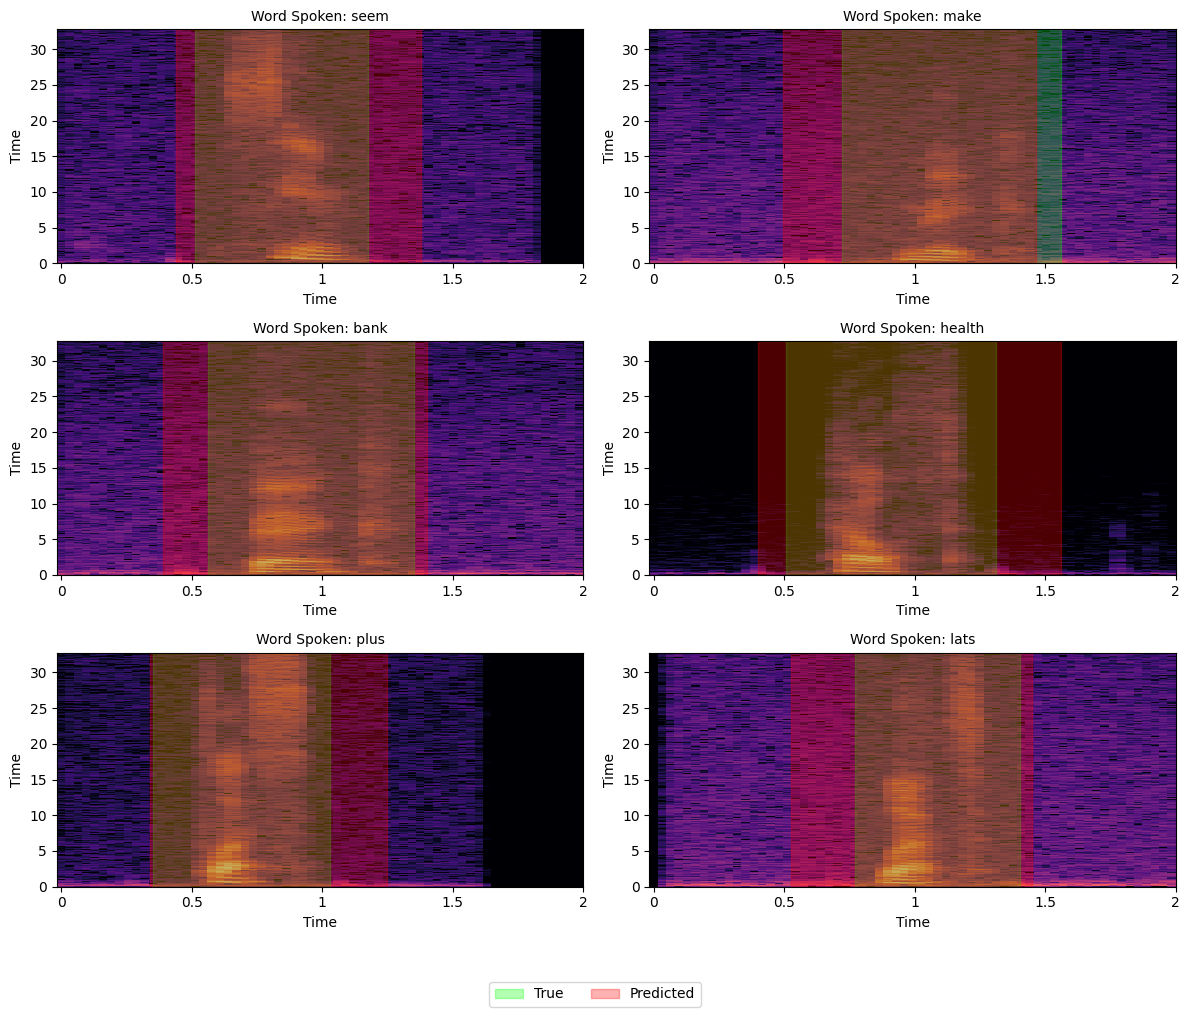

In [27]:
sample_files = ["seem_10.wav", "make_16.wav", "bank_21.wav", "health_30.wav", "plus_40.wav", "lats_45.wav"]
# from augmentation.ipynb
df_aug = pd.read_csv("augmented_data.csv")

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, filename in enumerate(sample_files):
    audio_path = os.path.join("aug_audio", filename)
    y, sr = librosa.load(audio_path, sr=16000)

    # Spectrogram
    ax = axes[i]
    S = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(S, sr=sr, x_axis="time", y_axis="time", ax=ax)

    # Get ground truth
    row = df_aug[df_aug["audio"] == filename].iloc[0]
    start = row["start_time"]
    end = row["end_time"]

    # Plot ground truth (green)
    ax.axvspan(start, end, color="lime", alpha=0.3, label="True")

    # Get prediction
    pred_start, pred_end = predict_start_and_end(model, audio_path)

    # Plot prediction (red)
    ax.axvspan(pred_start, pred_end, color="red", alpha=0.3, label="Predicted")

    # Title
    ax.set_title(f"Word Spoken: {filename.split('_')[0]}", fontsize=10)

# Shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 0.02))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()